
## IS 608 Homework 4
#### Tom Detzel
**March 26, 2017**
***
***

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gmean
from bokeh.charts import TimeSeries, show, BoxPlot, Bar, Scatter, Histogram
from bokeh.io import output_notebook, push_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
import seaborn as sns
# import plotly.plotly as py
# import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
output_notebook()

Loading BokehJS ...

***
## Get started with our data
We're grabbing the raw .csv file from Charley's github folder.
***

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/charleyferrari/CUNY_DATA608/master/lecture4/Data/riverkeeper_data_2013.csv")


### Have a peek
Here's the structure; looking deeper shows that the EnteroCount variable has some slop: the entries include "<" and ">" signs that we'll need to remove.

In [4]:
df.head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,10/16/2011,1733,1.5,35
1,Hudson above Mohawk River,10/21/2013,4,0.2,35
2,Hudson above Mohawk River,9/21/2013,20,0.0,35
3,Hudson above Mohawk River,8/19/2013,6,0.0,35
4,Hudson above Mohawk River,7/21/2013,31,0.0,35


### Check data types
Indeed, Date and EnteroCount are the wrong types; they need to be Date and Integer, respectively.

In [5]:
df.dtypes

Site                 object
Date                 object
EnteroCount          object
FourDayRainTotal    float64
SampleCount           int64
dtype: object

### Fix data types, stray characters
Transform 'em while you got 'em. We'll use pandas to make the Date field DateTime.

In [6]:
df['EnteroCount'].replace('<', "", regex=True, inplace=True)

In [7]:
df['EnteroCount'].replace('>', "", regex=True, inplace=True)

In [8]:
df['EnteroCount'] = df['EnteroCount'].astype(int)

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

### That's better.

In [10]:
df.dtypes

Site                        object
Date                datetime64[ns]
EnteroCount                  int64
FourDayRainTotal           float64
SampleCount                  int64
dtype: object

In [11]:
df.head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
0,Hudson above Mohawk River,2011-10-16,1733,1.5,35
1,Hudson above Mohawk River,2013-10-21,4,0.2,35
2,Hudson above Mohawk River,2013-09-21,20,0.0,35
3,Hudson above Mohawk River,2013-08-19,6,0.0,35
4,Hudson above Mohawk River,2013-07-21,31,0.0,35


### Unique sites
There are 75 unique measuring sites.

In [12]:
len(df['Site'].unique())

75

***
## Best and Worst Places to Swim
We'll look at mean and geometric mean measurements of Enterococcus levels by site, then sort by contamination levels.
***

### A function to get some stats
We'll apply his to each variable to get max, min, count and a mean.

In [13]:
# function to calculate group stats; used with apply()
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

### Highest Geometric mean Enterococcus readings
After computing the stats, here are the worst 10 sites by overall average contamination. No surprise if you've been on the Gowanus (now a rapidly gentrifying area for Brookly hipsters). Don't swim there. There is no method in pandas to calc the geometric mean, so we have to do it in regular Python using the gmean() function from scipy. Arrrgh.

In [14]:
grouped_df = df.groupby(['Site'])

### Highest Geometric Mean Enteroccocus readings
Slightly different ranking, but all well above the 30/mL standard.

In [15]:
grouped_df['EnteroCount'].apply(gmean, axis=None).reset_index().sort_values(by='EnteroCount', ascending=0)[0:9]

,Site,EnteroCount
70,Upper Sparkill Creek,387.184599
29,Gowanus Canal,181.330620
45,Mohawk River at Waterford,169.718920
48,Newtown Creek- Metropolitan Ave. Bridge,147.728997
63,Saw Mill River,115.117277
57,Piermont Pier,106.641987
34,Hudson River above Troy Lock,105.365758
46,Newburgh Launch Ramp,102.579356
41,Kingston STP Outfall,102.225027


### Lowest Geometric Mean Enteroccocus readings
Keepin' it clean upstate. How about them Catskills?

In [16]:
grouped_df['EnteroCount'].apply(gmean, axis=None).reset_index().sort_values(by='EnteroCount', ascending=1)[0:9]

,Site,EnteroCount
10,Catskill Creek- First Bridge,0.000000
50,Norrie Point mid-channel,3.909624
59,Poughkeepsie Drinking Water Intake,4.381236
58,Port Ewen Drinking Water Intake,5.257241
68,Tivoli Landing,6.926002
42,Little Stony Point,7.887391
69,Ulster Landing Beach,8.779956
72,West Point STP Outfall,9.210815
44,Marlboro Landing,9.661643


### Plot Best and Worst
Unfortunately, Bokeh would not let me override the default alphabetical sort on the x-axis label names. I have no idea why. I tried the code in the docs: labels = cat('Site', sort=False). I do like the way it automatically 45s the long label names.

In [17]:
df_geo = grouped_df['EnteroCount'].apply(gmean, axis=None).reset_index().sort_values(by='EnteroCount', ascending=1)

In [18]:
worst = df_geo.tail(20).sort_values('EnteroCount', ascending=1)

In [19]:
best = df_geo.head(20).sort_values('EnteroCount', ascending=1)

In [20]:
p = Bar(worst, 'Site', values='EnteroCount', 
            title="Worst 20 Enterococcus readings by Site",
            color="lightblue", legend=False, xlabel="")

show(p, notebook_handle=True)

In [21]:
p = Bar(best, 'Site', values='EnteroCount', 
            title="Best 20 Enterococcus readings by Site",
            color="lightblue", legend=False, xlabel="")

show(p, notebook_handle=True)

### Distribution of Enterococcus Readings
Bokeh would not let me make a simple bar chart that of all the readings that wasn't a mess. So here is a histogram showing the left skew in the data. Most of the readings are below the 30 per 100Ml level.

In [22]:
p = Histogram(df_geo['EnteroCount'], bins=100, 
                  title="Distribution of Geometric Means")

show(p, notebook_handle=True)

***
## Time Span Between Measurements
***


### Indexing on Time
We need to create a new index based on the Date field. This will make stuff easier.

In [23]:
df2 = df

In [24]:
df2.index = df['Date']

In [25]:
df2.groupby('Site').count().sort_values(by='SampleCount', ascending=0).head()

,Date,EnteroCount,FourDayRainTotal,SampleCount
Site,,,,
Piermont Pier,187,187,187,187
Upper Sparkill Creek,165,165,165,165
125th St. Pier,66,66,66,66
Nyack Launch Ramp,61,61,61,61
Newtown Creek- Dutch Kills,57,57,57,57


### Find some sites with high, low rates of testing
The range overall is quite wide, with Piermont Pier having 187 testing days and many sites with only one. Here we select four sites on either end and make quick exploratory plots in matplot.

In [26]:
piermont = df2[df2['Site'] == 'Piermont Pier']

In [27]:
sparkill = df2[df2['Site'] == 'Upper Sparkill Creek']

In [28]:
marlboro = df2[df2['Site'] == 'Marlboro Landing']

In [29]:
tarrytown = df2[df2['Site'] == 'Tarrytown Marina']

#### Peek at the Piedmont data


In [30]:
piermont.sort_values(by='Date', ascending=1).head()

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount
Date,,,,,
2006-10-17,Piermont Pier,2006-10-17,200,1.1,187
2006-10-18,Piermont Pier,2006-10-18,1120,1.1,187
2006-10-28,Piermont Pier,2006-10-28,1275,2.5,187
2006-12-06,Piermont Pier,2006-12-06,132,0.0,187
2007-04-18,Piermont Pier,2007-04-18,1104,8.5,187


### The plots

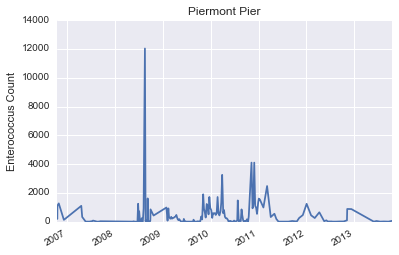

In [31]:
ax = piermont['EnteroCount'].plot()
ax.set_ylabel('Enterococcus Count')
ax.set_xlabel("")
ax.set_title("Piermont Pier")

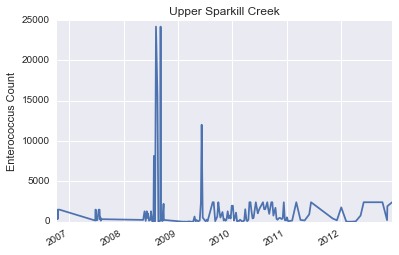

In [32]:
ax = sparkill['EnteroCount'].plot()
ax.set_ylabel('Enterococcus Count')
ax.set_xlabel("")
ax.set_title("Upper Sparkill Creek")

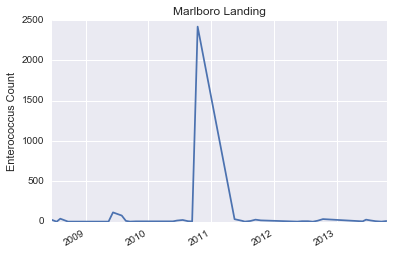

In [33]:
ax = marlboro['EnteroCount'].plot()
ax.set_ylabel('Enterococcus Count')
ax.set_xlabel("")
ax.set_title("Marlboro Landing")

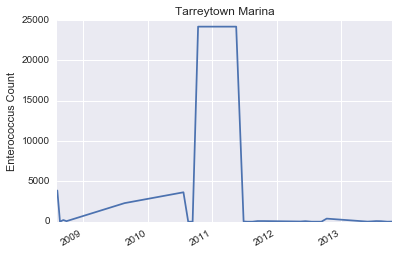

In [34]:
ax = tarrytown['EnteroCount'].plot()
ax.set_ylabel('Enterococcus Count')
ax.set_xlabel("")
ax.set_title("Tarreytown Marina")

***
### Rainfall and Bacteria

The chart shows overall enterococcus sampling by rainfall. Although the overall correlation is weak (.14), it's clear that low water it does appea that high contamination is reported when rainfall is low, which is intuitive. This needs more explortion.
***


In [35]:
p = Scatter(df2, x='FourDayRainTotal', y='EnteroCount', 
                  xlabel="Four Day Rain Total", ylabel='Enterococcus Count',
                  title="Bacteria counts by Site")

show(p, notebook_handle=True)

In [36]:
np.corrcoef(df['EnteroCount'], df['FourDayRainTotal'])[1][0]

0.14482598724767226